# Model Parameter Tuning

In [3]:
import itertools
import os
import sys

import itertools
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from datetime import datetime, timedelta
from plotly.subplots import make_subplots
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.utilities import regressor_coefficients
from tqdm.notebook import tqdm

In [6]:
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/src")

from conf.database import db

Connecting to database.
Connection successful.


In [7]:
target="16019"

start_time = datetime.strptime("2019/12/15", "%Y/%m/%d")
no_of_hours=23

## Feature selection

In [8]:
query = {}
project = {"_id": 0, "Datetime": 1, target:1}
df = (
    pd.DataFrame(
        db["WESSEX_E_Numbers_Apr_2019_60Min_Mean"].find(query, project)
    )
    .set_index("Datetime")
    .sort_index()
)
query = {}
project = {"_id": 0}
rain_df = pd.DataFrame(
    db["WESSEX_Rain_Apr_2019_Processed"].find(query, project)
).set_index("Datetime").sort_index()
rain_df

rain_1h  rain_7h_cent_mean  rain_7h_cent_max  \
Datetime                                                            
2019-04-01 00:00:00      0.0               0.00               0.0   
2019-04-01 01:00:00      0.0               0.00               0.0   
2019-04-01 02:00:00      0.0               0.00               0.0   
2019-04-01 03:00:00      0.0               0.00               0.0   
2019-04-01 04:00:00      0.0               0.00               0.0   
...                      ...                ...               ...   
2020-03-18 19:00:00      0.2               0.21               0.5   
2020-03-18 20:00:00      0.2               0.24               0.5   
2020-03-18 21:00:00      0.0               0.24               0.5   
2020-03-18 22:00:00      0.2               0.24               0.5   
2020-03-18 23:00:00      0.2               0.24               0.5   

                     rain_5h_cent_mean  
Datetime                                
2019-04-01 00:00:00               0.00  
2019-04-01 01:00:00               0.00  
2019-04-01 02:00:00               0.00  
2019-04-01 03:00:00               0.00  
2019-04-01 04:00:00               0.00  
...                                ...  
2020-03-18 19:00:00               0.26  
2020-03-18 20:00:00               0.22  
2020-03-18 21:00:00               0.16  
2020-03-18 22:00:00               0.16  
2020-03-18 23:00:00               0.16  

[8472 rows x 4 columns]

In [5]:
rain_fig = make_subplots(
    rows=4,
    cols=1,
    vertical_spacing=0.1,
    subplot_titles=["Hourly Rainfall (mm)"],
    shared_xaxes=True
) 
rain_fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df[target],
        name=target
    ),
    row=1,
    col=1,
)
rain_fig.add_trace(
    go.Scatter(
        x=rain_df.index,
        y=rain_df["rain_shift-1"],
        name='rain_shift-1'
    ),
    row=2,
    col=1,
)
rain_fig.add_trace(
    go.Scatter(
        x=rain_df.index,
        y=rain_df["rain_7h_cent_mean"],
        name="7h_cent_mean",
    ),
    row=3,
    col=1,
)
rain_fig.add_trace(
    go.Scatter(
        x=rain_df.index,
        y=rain_df["rain_7h_cent_max"],
        name="7h_cent_max",
    ),
    row=4,
    col=1,
)
rain_fig.update_layout(
    height=600
)
rain_fig.show()

NameError: name 'df' is not defined

In [6]:
res_df = pd.concat([df, rain_df], axis=1)
res_df = res_df.reset_index().rename(columns={"Datetime": "ds", target: "y"})
res_df

NameError: name 'df' is not defined

In [7]:
train_pc = 0.5
split = int(len(res_df)*train_pc)
train = res_df.iloc[:split]
test = res_df.iloc[split:]

regressor_list = ['rain_7h_cent_mean']
m = Prophet(yearly_seasonality=False)
for regressor in regressor_list:
    m.add_regressor(regressor, standardize=True)
m.fit(train)

forecast = m.predict(test.drop('y', axis=1))

In [8]:
regressor_coefficients(m)

regressor regressor_mode    center  coef_lower      coef  \
0  rain_7h_cent_mean       additive  0.141133    8.712662  8.712662   

   coef_upper  
0    8.712662

## Regressor selection

In [9]:
regressor_list = rain_df.columns.to_list()
regressor_grid = sum([list(map(list, itertools.combinations(regressor_list, i))) for i in range(len(regressor_list) + 1)], [])
regressor_rmses = []

for regressor_list in tqdm(regressor_grid):
    m = Prophet(yearly_seasonality=False)
    for regressor in regressor_list:
        m.add_regressor(regressor, standardize=True)
    m.fit(train)
    forecast = m.predict(test.drop('y', axis=1))
    
    se = np.square(forecast['yhat'] - test.reset_index(drop=True)['y'])
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    regressor_rmses.append(rmse)

  0%|          | 0/16 [00:00<?, ?it/s]

In [10]:
regressor_results = pd.DataFrame(regressor_grid)
regressor_results['rmse']=regressor_rmses
regressor_results

0                  1                  2  \
0                None               None               None   
1        rain_shift-1               None               None   
2   rain_7h_cent_mean               None               None   
3    rain_7h_cent_max               None               None   
4   rain_5h_cent_mean               None               None   
5        rain_shift-1  rain_7h_cent_mean               None   
6        rain_shift-1   rain_7h_cent_max               None   
7        rain_shift-1  rain_5h_cent_mean               None   
8   rain_7h_cent_mean   rain_7h_cent_max               None   
9   rain_7h_cent_mean  rain_5h_cent_mean               None   
10   rain_7h_cent_max  rain_5h_cent_mean               None   
11       rain_shift-1  rain_7h_cent_mean   rain_7h_cent_max   
12       rain_shift-1  rain_7h_cent_mean  rain_5h_cent_mean   
13       rain_shift-1   rain_7h_cent_max  rain_5h_cent_mean   
14  rain_7h_cent_mean   rain_7h_cent_max  rain_5h_cent_mean   
15       rain_shift-1  rain_7h_cent_mean   rain_7h_cent_max   

                    3       rmse  
0                None  16.839927  
1                None  16.064222  
2                None  14.886061  
3                None  14.920626  
4                None  15.059506  
5                None  14.965859  
6                None  14.898782  
7                None  15.142099  
8                None  14.867851  
9                None  15.003229  
10               None  14.820543  
11               None  14.898798  
12               None  14.978980  
13               None  14.838704  
14               None  14.931401  
15  rain_5h_cent_mean  14.961784

In [11]:
best_params = regressor_results.loc[[np.argmin(regressor_rmses)]]
best_params

0                  1     2     3       rmse
10  rain_7h_cent_max  rain_5h_cent_mean  None  None  14.820543

In [ ]:
# rain_7h_cent_mean is generally sufficient, without overfitting

## Cross validation

In [9]:
regressor_list = ['rain_7h_cent_mean']
res_df = res_df.drop(['rain_shift-1', 'rain_7h_cent_max', 'rain_5h_cent_mean'], axis=1)

m = Prophet(yearly_seasonality=False)
for regressor in regressor_list:
    m.add_regressor(regressor, standardize=True)
m.fit(res_df)
df_cv = cross_validation(m, initial='200 days', period='15 days', horizon = '30 days')

Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 13:23:13.215 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse       mae      mape     mdape  \
0 3 days 00:00:00  142.601037  11.941568  6.890596  0.081785  0.072220   
1 3 days 01:00:00  146.510250  12.104142  6.954756  0.082208  0.072401   
2 3 days 02:00:00  149.222653  12.215672  7.008105  0.082567  0.072564   
3 3 days 03:00:00  149.235480  12.216197  7.010734  0.082612  0.072670   
4 3 days 04:00:00  149.481693  12.226271  7.029938  0.082875  0.072564   

      smape  coverage  
0  0.082193  0.932099  
1  0.082757  0.930556  
2  0.083231  0.929012  
3  0.083265  0.929012  
4  0.083501  0.927469

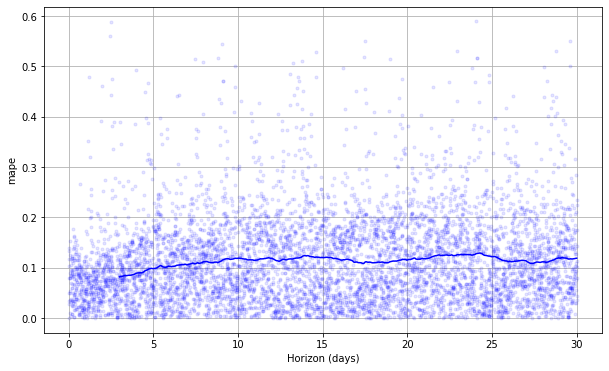

In [12]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Hyperparameter tuning

In [18]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
regressor_list = ['rain_7h_cent_mean']

for params in all_params:
    print(params)
    m = Prophet(**params, yearly_seasonality=False)  # Fit model with given params
    for regressor in regressor_list:
        m.add_regressor(regressor, standardize=True)
    m.fit(res_df)
    df_cv = cross_validation(m, initial='200 days', period='15 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:22:17.919 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949effb890>
2021-05-14 15:22:17.921 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949effb890>


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:24:25.162 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f24c6d0>
2021-05-14 15:24:25.164 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f24c6d0>


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:26:05.117 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f201e950>
2021-05-14 15:26:05.119 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f201e950>


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:27:41.246 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f2e8550>
2021-05-14 15:27:41.248 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f2e8550>


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:29:10.989 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f1dc650>
2021-05-14 15:29:10.991 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f1dc650>


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:30:40.895 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f200b790>
2021-05-14 15:30:40.897 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f200b790>


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:32:15.797 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94a930a710>
2021-05-14 15:32:15.799 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94a930a710>


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:33:38.325 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f201e950>
2021-05-14 15:33:38.326 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f201e950>


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:35:16.971 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f2e38a50>
2021-05-14 15:35:16.972 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f2e38a50>


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:36:56.304 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94a930a450>
2021-05-14 15:36:56.306 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94a930a450>


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:38:41.479 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f15c610>
2021-05-14 15:38:41.481 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f15c610>


{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:40:23.374 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f95493dd110>
2021-05-14 15:40:23.375 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f95493dd110>


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:42:03.310 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f06d3d0>
2021-05-14 15:42:03.311 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f949f06d3d0>


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:43:46.465 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f20f8cd0>
2021-05-14 15:43:46.467 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f20f8cd0>


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:45:45.910 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94a8b7ded0>
2021-05-14 15:45:45.912 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94a8b7ded0>


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-14 15:47:46.650 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f18faf10>
2021-05-14 15:47:46.652 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f94f18faf10>


    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  13.463152
1                     0.001                     0.10  13.460191
2                     0.001                     1.00  13.461151
3                     0.001                    10.00  13.468924
4                     0.010                     0.01  13.859162
5                     0.010                     0.10  13.858849
6                     0.010                     1.00  13.858803
7                     0.010                    10.00  13.847664
8                     0.100                     0.01  14.582241
9                     0.100                     0.10  14.582958
10                    0.100                     1.00  14.588996
11                    0.100                    10.00  14.586557
12                    0.500                     0.01  14.631152
13                    0.500                     0.10  14.636535
14                    0.500             

In [20]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


In [5]:
query = {}
project = {"_id": 0, "Datetime": 1, target:1}
df = (
    pd.DataFrame(
        db["WESSEX_E_Numbers_Apr_2019_60Min_Mean"].find(query, project)
    )
    .set_index("Datetime")
    .sort_index()
)
query = {}
project = {"_id": 0}
rain_df = pd.DataFrame(
    db["WESSEX_Rain_Apr_2019_Processed"].find(query, project)
).set_index("Datetime").sort_index()
rain_df

res_df = pd.concat([df, rain_df], axis=1)
res_df = res_df.reset_index().rename(columns={"Datetime": "ds", target: "y"})
res_df = res_df.drop(['rain_1h', 'rain_7h_cent_max', 'rain_5h_cent_mean'], axis=1)
res_df

ds          y  rain_7h_cent_mean
0    2019-04-01 00:00:00  70.992227               0.00
1    2019-04-01 01:00:00  70.258480               0.00
2    2019-04-01 02:00:00  69.698608               0.00
3    2019-04-01 03:00:00  70.934903               0.00
4    2019-04-01 04:00:00  69.090976               0.00
...                  ...        ...                ...
8467 2020-03-18 19:00:00  95.257573               0.21
8468 2020-03-18 20:00:00  87.440458               0.24
8469 2020-03-18 21:00:00  82.575544               0.24
8470 2020-03-18 22:00:00  84.438580               0.24
8471 2020-03-18 23:00:00  73.277556               0.24

[8472 rows x 3 columns]

In [6]:
query = {}
project = {"_id": 0, "Datetime": 1, target:1}
df = (
    pd.DataFrame(
        db["WESSEX_E_Numbers_Apr_2019_60Min_Mean"].find(query, project)
    )
    .set_index("Datetime")
    .sort_index()
)
query = {}
project = {"_id": 0}
rain_df = pd.DataFrame(
    db["WESSEX_Rain_Apr_2019_Processed"].find(query, project)
).set_index("Datetime").sort_index()
rain_df

res_df = pd.concat([df, rain_df], axis=1)
res_df = res_df.reset_index().rename(columns={"Datetime": "ds", target: "y"})
res_df = res_df.drop(['rain_1h', 'rain_7h_cent_max', 'rain_5h_cent_mean'], axis=1)

param_grid = {  
    'changepoint_range': [0.1, 0.33, 0.66, 1],
    'interval_width': [0.1, 0.33, 0.66, 1],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
regressor_list = ['rain_7h_cent_mean']

for params in all_params:
    print(params)
    m = Prophet(**params, yearly_seasonality=False)  # Fit model with given params
    for regressor in regressor_list:
        m.add_regressor(regressor, standardize=True)
    m.fit(res_df)
    df_cv = cross_validation(m, initial='200 days', period='15 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

{'changepoint_range': 0.1, 'interval_width': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 13:52:39.744 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba706befd0>
2021-05-19 13:52:39.750 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba706befd0>


{'changepoint_range': 0.1, 'interval_width': 0.33}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 13:54:38.070 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba704d5550>
2021-05-19 13:54:38.072 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba704d5550>


{'changepoint_range': 0.1, 'interval_width': 0.66}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 13:56:35.399 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba7050bf10>
2021-05-19 13:56:35.401 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba7050bf10>


{'changepoint_range': 0.1, 'interval_width': 1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 13:58:58.996 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba6fae4810>
2021-05-19 13:58:58.998 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba6fae4810>


{'changepoint_range': 0.33, 'interval_width': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:00:49.786 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbaa7cda550>
2021-05-19 14:00:49.789 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbaa7cda550>


{'changepoint_range': 0.33, 'interval_width': 0.33}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:02:51.007 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba7050bf10>
2021-05-19 14:02:51.009 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba7050bf10>


{'changepoint_range': 0.33, 'interval_width': 0.66}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:04:34.973 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbaa772d590>
2021-05-19 14:04:34.976 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbaa772d590>


{'changepoint_range': 0.33, 'interval_width': 1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:06:20.031 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbab9911d10>
2021-05-19 14:06:20.033 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbab9911d10>


{'changepoint_range': 0.66, 'interval_width': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:08:37.632 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbad481f5d0>
2021-05-19 14:08:37.634 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbad481f5d0>


{'changepoint_range': 0.66, 'interval_width': 0.33}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:10:35.547 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbaa7cda310>
2021-05-19 14:10:35.549 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbaa7cda310>


{'changepoint_range': 0.66, 'interval_width': 0.66}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:12:33.396 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbad481ffd0>
2021-05-19 14:12:33.398 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbad481ffd0>


{'changepoint_range': 0.66, 'interval_width': 1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:14:23.619 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbab982bbd0>
2021-05-19 14:14:23.621 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbab982bbd0>


{'changepoint_range': 1, 'interval_width': 0.1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:16:28.491 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbb0ab8f710>
2021-05-19 14:16:28.493 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbb0ab8f710>


{'changepoint_range': 1, 'interval_width': 0.33}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:18:31.603 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba75dd72d0>
2021-05-19 14:18:31.605 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba75dd72d0>


{'changepoint_range': 1, 'interval_width': 0.66}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:20:46.199 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbab9911d10>
2021-05-19 14:20:46.201 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbab9911d10>


{'changepoint_range': 1, 'interval_width': 1}


Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
2021-05-19 14:23:16.089 INFO    prophet: Making 9 forecasts with cutoffs between 2019-10-20 23:00:00 and 2020-02-17 23:00:00
Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba70c93950>
2021-05-19 14:23:16.091 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fba70c93950>


    changepoint_range  interval_width       rmse
0                0.10            0.10  13.469199
1                0.10            0.33  13.469199
2                0.10            0.66  13.469199
3                0.10            1.00  13.469199
4                0.33            0.10  13.536251
5                0.33            0.33  13.536251
6                0.33            0.66  13.536251
7                0.33            1.00  13.536251
8                0.66            0.10  13.679627
9                0.66            0.33  13.679627
10               0.66            0.66  13.679627
11               0.66            1.00  13.679627
12               1.00            0.10  20.653667
13               1.00            0.33  20.653667
14               1.00            0.66  20.653667
15               1.00            1.00  20.653667


In [7]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_range': 0.1, 'interval_width': 0.1}


## Final model

In [13]:
train_pc = 0.8
split = int(len(res_df)*train_pc)
train = res_df.iloc[:split]
test = res_df.iloc[split:]

regressor_list = ['rain_7h_cent_mean']

m = Prophet(
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.1,
    yearly_seasonality=False,
    interval_width=1,
    changepoint_range=0.1,
)
for regressor in regressor_list:
    m.add_regressor(regressor, standardize=True)
m.fit(train)

forecast = m.predict(test.drop('y', axis=1))
se = np.square(forecast['yhat'] - test.reset_index(drop=True)['y'])
mse = np.mean(se)
rmse = np.sqrt(mse)
print(rmse)

13.403215290311927


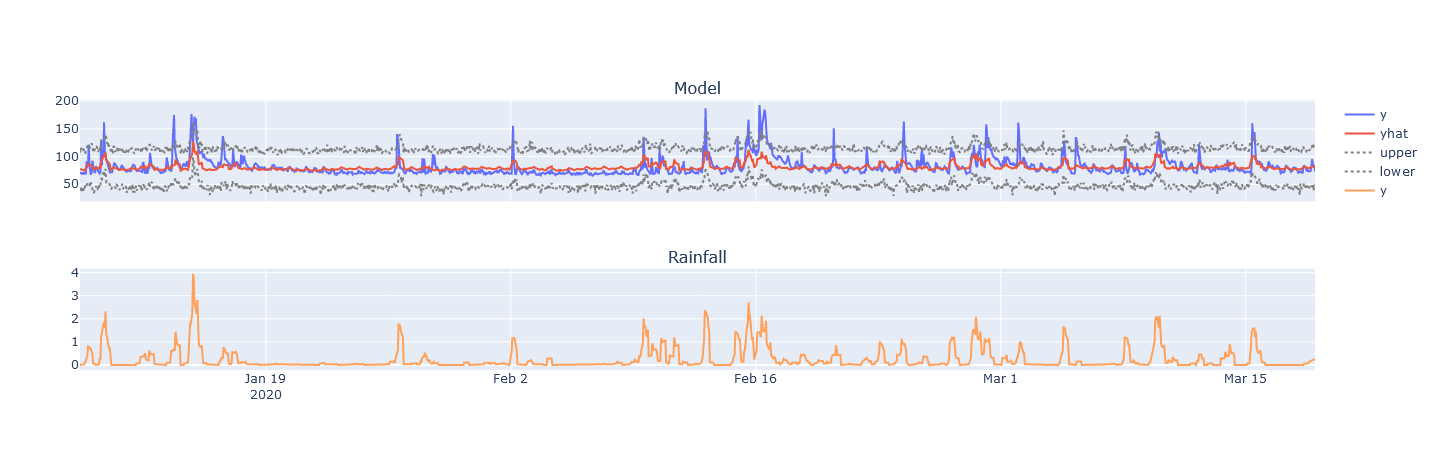

In [14]:
fig = make_subplots(
    subplot_titles=["Model", "Rainfall"],
    rows=2,
    cols=1,
    shared_xaxes=True
)
fig.add_trace(go.Scatter(x=test.ds, y=test.y, name='y'))
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='yhat'))
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat_upper, name='upper', line={'dash':'dot', 'color':'grey'}))
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat_lower, name='lower', line={'dash':'dot', 'color':'grey'}))

fig.add_trace(go.Scatter(x=test.ds, y=test.rain_7h_cent_mean, name='y'), row=2, col=1)


fig.show()

In [16]:
regressor_coefficients(m)

regressor regressor_mode    center  coef_lower       coef  \
0  rain_7h_cent_mean       additive  0.190896   13.069072  13.069072   

   coef_upper  
0   13.069072